In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F
plt.rcParams["savefig.bbox"] = 'tight'

In [2]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()

In [3]:
INPUT_SIZE = 28
BATCH_SIZE = 64
LR = 1e-4
Z_DIM = 64
IMG_DIM = INPUT_SIZE * INPUT_SIZE * 1

In [4]:
d_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = datasets.MNIST(root = "dataset/", train = True, transform = d_transforms, download = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [5]:
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True)

In [6]:
class Discriminator(nn.Module):
  def __init__(self, in_features) : 
    super().__init__()
    self.d = nn.Sequential(
        nn.Linear(in_features, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 1),
        nn.Sigmoid()
    )

  def forward(self, x) :
    return self.d(x)
  
d = Discriminator(5)
req = torch.Tensor(np.random.rand(10, 5))
res = d(req)
print(res.shape)

torch.Size([10, 1])


In [7]:
class Generator(nn.Module) :
  def __init__(self, z_dim, img_dim) : 
    '''
      z_dim     : Dimension of random noise
      img_dim   : Dimension image to be generated
    '''
    super().__init__()
    self.g = nn.Sequential(
        nn.Linear(z_dim, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, img_dim),
        nn.Tanh()
    )

  def forward(self, x) :
    return self.g(x)

g = Generator(10, 784)
req = torch.Tensor(np.random.rand(10, 10))
res = g(req)
print(res.shape)

torch.Size([10, 784])


In [8]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


In [9]:
DISC = Discriminator(IMG_DIM).to(DEVICE)
GEN = Generator(Z_DIM, IMG_DIM).to(DEVICE)

In [10]:
FIXED_NOISE = torch.randn((BATCH_SIZE, Z_DIM)).to(DEVICE)

In [11]:
OPT_DISC = optim.Adam(DISC.parameters(), lr=LR)
OPT_GEN = optim.Adam(GEN.parameters(), lr=LR)
CRITERION = nn.BCELoss()

Epoch [1/100]	 Loss D : 0.6818994879722595, Loss G : 0.6465034484863281


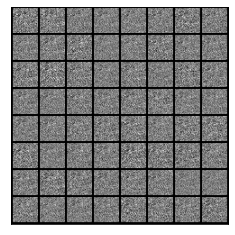

Epoch [5/100]	 Loss D : 0.1693538874387741, Loss G : 2.7749271392822266


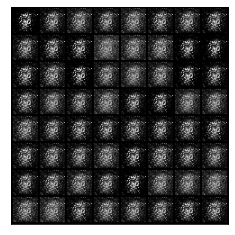

Epoch [10/100]	 Loss D : 0.20111241936683655, Loss G : 2.7247304916381836


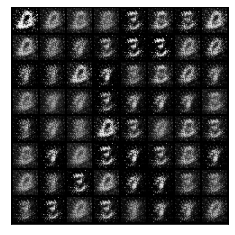

Epoch [15/100]	 Loss D : 0.20797431468963623, Loss G : 3.067960262298584


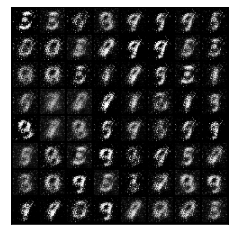

Epoch [20/100]	 Loss D : 0.11171187460422516, Loss G : 4.809922218322754


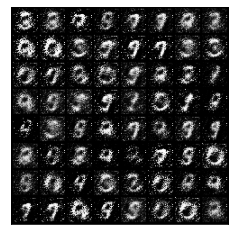

Epoch [25/100]	 Loss D : 0.21634121239185333, Loss G : 4.30095100402832


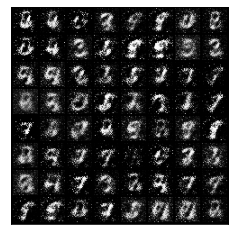

Epoch [30/100]	 Loss D : 0.36866500973701477, Loss G : 3.0600247383117676


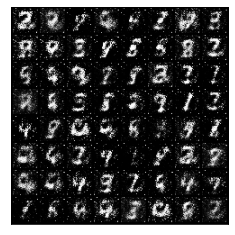

Epoch [35/100]	 Loss D : 0.2488437294960022, Loss G : 3.672478675842285


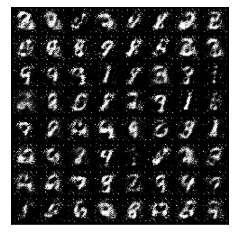

Epoch [40/100]	 Loss D : 0.37360525131225586, Loss G : 2.4223196506500244


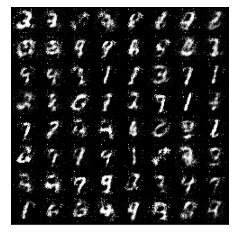

Epoch [45/100]	 Loss D : 0.3446199297904968, Loss G : 2.4273571968078613


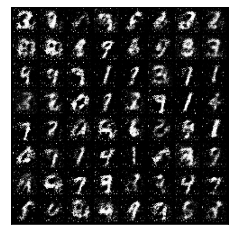

Epoch [50/100]	 Loss D : 0.3039543032646179, Loss G : 2.3648107051849365


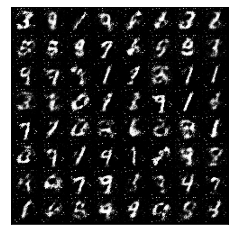

Epoch [55/100]	 Loss D : 0.30204445123672485, Loss G : 2.4907264709472656


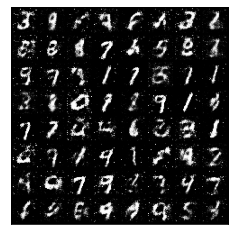

Epoch [60/100]	 Loss D : 0.3546633720397949, Loss G : 1.751504898071289


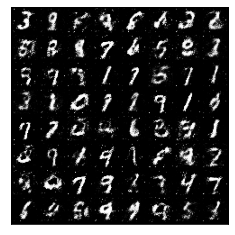

Epoch [65/100]	 Loss D : 0.4548444151878357, Loss G : 1.527922511100769


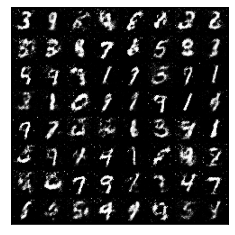

Epoch [70/100]	 Loss D : 0.452361524105072, Loss G : 1.804722547531128


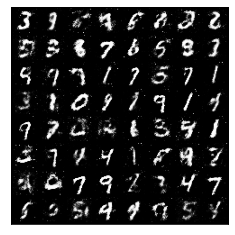

Epoch [75/100]	 Loss D : 0.4070602357387543, Loss G : 1.4598376750946045


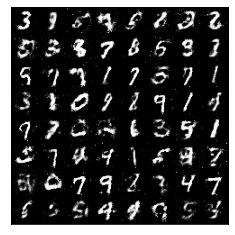

Epoch [80/100]	 Loss D : 0.42089352011680603, Loss G : 1.4258426427841187


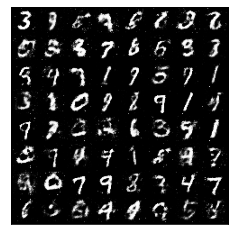

Epoch [85/100]	 Loss D : 0.5365618467330933, Loss G : 1.4376744031906128


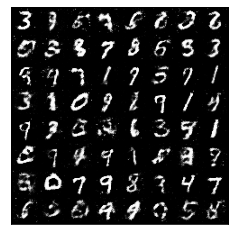

Epoch [90/100]	 Loss D : 0.5564735531806946, Loss G : 1.157235026359558


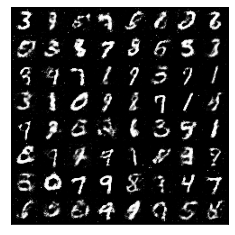

Epoch [95/100]	 Loss D : 0.5789325833320618, Loss G : 1.1958870887756348


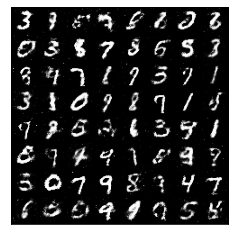

Epoch [100/100]	 Loss D : 0.5111151933670044, Loss G : 1.2796010971069336


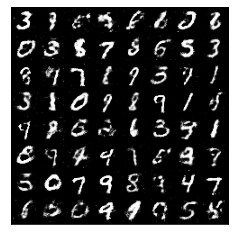

In [12]:
N_EPOCHS = 100

for epoch in range(N_EPOCHS) :
  for batch_idx, (real, _) in enumerate(dataloader) :
    real = real.view(-1, IMG_DIM).to(DEVICE)
    batch_size = real.shape[0]
    
    '''
      Discriminator training => max log(D(real)) + log(1 - D(fake)) ... 1

      BCE Loss (predicted x, true y) = - w [y * log x  + (1-y) * log (1 - x)] ... 2

      For real subset, y = 1
      So, (1-y)(log(1-x)) = 0
      and, BCE Loss => - log(x) ... 3

      So, BCE loss = - log (x) = - (log(D(real)))
      So, minimizing (1) => minimizing (3) => maximizing log(D(real))
    '''
    disc_real = DISC(real).view(-1)
    lossD_real = CRITERION(disc_real, torch.ones_like(disc_real))
    
    noise= torch.randn((batch_size, Z_DIM)).to(DEVICE)
    fake = GEN(noise).to(DEVICE)
    '''
      Discriminator training => max log(D(real)) + log(1 - D(fake)) ... 1

      BCE Loss (predicted x, true y) = - w [y * log x  + (1-y) * log (1 - x)] ... 2

      For fake subset, y = 0
      So, (y)(log(x)) = 0
      and, BCE Loss => - log(1-x) ... 3

      So, BCE loss = - log (1-x) = - (log(1-D(fake)))
      So, minimizing (1) => minimizing (3) => maximizing log(1-D(fake))
    '''
    # Method 1 : we use detach to prevent backpropagatioon on Generator
    # disc_fake = DISC(fake.detach()).view(-1) 
    disc_fake = DISC(fake).view(-1) 
    lossD_fake = CRITERION(disc_fake, torch.zeros_like(disc_fake))

    lossD = (lossD_real + lossD_fake)/2
    DISC.zero_grad()
    # Method 2 : We retain the graph loss so that we can backpropagate to retrain the generator later
    lossD.backward(retain_graph = True) 
    OPT_DISC.step()

    '''
      Generator Training => min log(1 - D(FAKE))
      However, to prevent saturating gradients, we do : max log(D(fake))
    '''
    output = DISC(fake).view(-1)
    lossG = CRITERION(output, torch.ones_like(output))
    GEN.zero_grad()
    lossG.backward()
    OPT_GEN.step()


    # Tensorboard Stuff
    if batch_idx == 0 and ( (epoch+1)%5==0 or epoch==0 ): 
      print(f"Epoch [{epoch+1}/{N_EPOCHS}]\t Loss D : {lossD}, Loss G : {lossG}")

      with torch.no_grad() : 
        fake = GEN(FIXED_NOISE).reshape(-1, 1, INPUT_SIZE, INPUT_SIZE)
        data = real.reshape(-1, 1, INPUT_SIZE, INPUT_SIZE)
        img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
        img_grid_real = torchvision.utils.make_grid(data, normalize=True)
        show(img_grid_fake)